In [1]:
import os
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
# Kerasの必要なコンポーネントをインポート
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.optimizers import RMSprop
from keras.utils import np_utils, plot_model

# Scikit-learn(Sklearn)のインポート
#  from sklearn.datasets import fetch_openml

# データを高速かつ効率的に使えるPandasをインポート
import pandas as pd
# 数値計算を効率的に行うNumpyをインポート
import numpy as np
#グラフが簡単に描写できるMatplotlibをインポート
import matplotlib
import matplotlib.pyplot as plt

#astropy関連のインポート
from astropy.table import Table

#csv
import csv

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [4]:
import datetime
import pydot

In [5]:
 # Clear any logs from previous runs
!rm -rf ./logs/ 

'rm' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


# テスト - 一旦画像表示させてみる

In [5]:
galaxy_arr = np.load("data/npz/587727178986356823.npy")

In [19]:
# 画像
print(galaxy_arr)
print(galaxy_arr.shape)

[[1196 1188 1197 ... 1191 1191 1187]
 [1179 1185 1179 ... 1196 1189 1191]
 [1194 1189 1197 ... 1194 1199 1196]
 ...
 [1188 1189 1194 ... 1187 1202 1186]
 [1179 1189 1190 ... 1199 1195 1205]
 [1196 1196 1189 ... 1187 1189 1185]]
(60, 60)


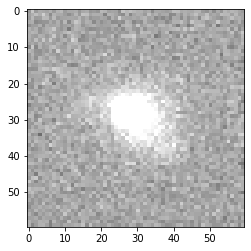

In [7]:
# 画像表示
plt.imshow(np.log10(galaxy_arr.T[::-1, ::-1]), cmap='gray', vmin=3.05, vmax=3.09)

In [17]:
#最大値参照
print(np.argmax(galaxy_arr)) #これは平坦化した際のインデックス
print(np.unravel_index(np.argmax(galaxy_arr),galaxy_arr.shape))
print(galaxy_arr[31,31])

1891
(31, 31)
1516


# テスト - Table比較

In [19]:
# ラベル
print(galaxy_arr['arr_1'])

(587727178986356823, b'00:00:00.41', b'-10:22:25.7', 59, 0.61, 0.034, 0., 0.153, 0.153, 0.051, 0.186, 0.61, 0.186, 0, 0, 1)


ここでTableと比較してみる

In [26]:
table_hontai = Table.read('GalaxyZoo1_DR_table2.fits')
table_hontai[0]

OBJID,RA,DEC,NVOTE,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN
,hms,dms,,,,,,,,,,,,,
int64,bytes11,bytes11,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16
587727178986356823,00:00:00.41,-10:22:25.7,59,0.61,0.034,0.0,0.153,0.153,0.051,0.186,0.61,0.186,0,0,1


# データセット生成

In [67]:
# npzディレクトリのファイル名取得
#path = "data/npz"
#files = os.listdir(path)
#files_file = [f for f in files if os.path.isfile(os.path.join(path, f))]

#dataset_gal = []
#for npzname in files_file[:1]:
#    galaxy_arr = np.load('data/npz/' + npzname)
#    header = galaxy_arr['arr_1']
#    print(header)
    

(588015509806252189, b'00:00:26.31', b'+00:35:50.8', 26, 0.654, 0., 0., 0.231, 0.115, 0., 0.231, 0.394, 0.447, 0, 0, 1)


In [104]:
# まず、作成したcsvをロード
csv_obj = open('data/csv/galaxy_csv.csv')
csv_reader = csv.reader(csv_obj)
gz_table = [row for row in csv_reader]

In [105]:
# x(画像データ)のロード
x = [np.load('data/npz/' + i[0] + '.npy') for i in gz_table[:1000]]

In [106]:
print(x[0])
print(x[0].dtype)

[[1196 1188 1197 ... 1191 1191 1187]
 [1179 1185 1179 ... 1196 1189 1191]
 [1194 1189 1197 ... 1194 1199 1196]
 ...
 [1188 1189 1194 ... 1187 1202 1186]
 [1179 1189 1190 ... 1199 1195 1205]
 [1196 1196 1189 ... 1187 1189 1185]]
uint16


In [107]:
# list → nparray、およびint → float
X = np.array(x)
X = X.astype('float32')

In [108]:
print(X[0])
print(X[0].dtype)

[[1196. 1188. 1197. ... 1191. 1191. 1187.]
 [1179. 1185. 1179. ... 1196. 1189. 1191.]
 [1194. 1189. 1197. ... 1194. 1199. 1196.]
 ...
 [1188. 1189. 1194. ... 1187. 1202. 1186.]
 [1179. 1189. 1190. ... 1199. 1195. 1205.]
 [1196. 1196. 1189. ... 1187. 1189. 1185.]]
float32


In [109]:
# 正規化
for i in range(len(gz_table)):
    idx = np.unravel_index(np.argmax(X[i]), X[i].shape)
    idx_content = X[i][idx]
    X[i] = X[i]/idx_content

In [110]:
# y(正解ラベル)をロード
Y = []
for i in gz_table[:1000]:
    if i[13] == '1':
        Y.append(0)
    elif i[14] == '1':
        Y.append(1)
    elif i[15] == '1':
        Y.append(2)

In [111]:
# ワンホットエンコーディング
Y = np_utils.to_categorical(Y,3)

In [112]:
# 訓練データとテストデータを切り分ける
X_train, X_test, Y_train, Y_test = X[:800], X[800:], Y[:800], Y[800:]
Y_test_backup = Y_test

X_train = X_train.reshape(800, 60, 60, 1)
X_test  = X_test.reshape(200, 60, 60, 1)

# 両方のサイズを確認
print(len(X_train))
print(X_train[0].shape)
print(type(X_train))

800
(60, 60, 1)
<class 'numpy.ndarray'>


# モデル構築とトレーニング

In [113]:
# Parameter
batch_size = 64
epochs = 500

# Model Construction                                                                                
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(60, 60, 1)))
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])



# Learning and Score                                                                                
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 128)        

800/800 [==============================] - 6s 7ms/step - loss: 0.8595 - accuracy: 0.5850 - val_loss: 0.8761 - val_accuracy: 0.6050
Epoch 44/100
800/800 [==============================] - 5s 6ms/step - loss: 0.8436 - accuracy: 0.6062 - val_loss: 0.9107 - val_accuracy: 0.5850
Epoch 45/100
800/800 [==============================] - 5s 6ms/step - loss: 0.8364 - accuracy: 0.5825 - val_loss: 0.9230 - val_accuracy: 0.6100
Epoch 46/100
800/800 [==============================] - 6s 7ms/step - loss: 0.8339 - accuracy: 0.5987 - val_loss: 0.8994 - val_accuracy: 0.6100
Epoch 47/100
800/800 [==============================] - 6s 7ms/step - loss: 0.8251 - accuracy: 0.6062 - val_loss: 0.9406 - val_accuracy: 0.5650
Epoch 48/100
800/800 [==============================] - 6s 7ms/step - loss: 0.8441 - accuracy: 0.5925 - val_loss: 0.8902 - val_accuracy: 0.5850
Epoch 49/100
800/800 [==============================] - 5s 6ms/step - loss: 0.8324 - accuracy: 0.5962 - val_loss: 0.9567 - val_accuracy: 0.6100
Epoch

Epoch 100/100
800/800 [==============================] - 5s 6ms/step - loss: 0.7407 - accuracy: 0.6363 - val_loss: 1.0291 - val_accuracy: 0.6150
Test loss: 1.0290629386901855
Test accuracy: 0.6150000095367432


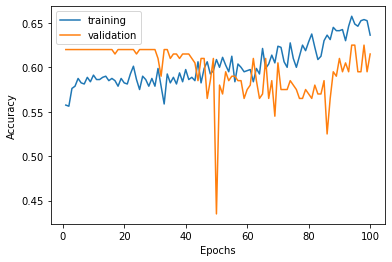

In [119]:
# 可視化、およびhistory避難
plt.plot(range(1,epochs+1), history.history['accuracy'], label="training")
plt.plot(range(1,epochs+1), history.history['val_accuracy'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

history_201010 = history

In [16]:
# tensorboard　(準備中) 
%tensorboard --logdir logs/fit

In [18]:
# X_testを使って予測を行う
predictions = model.predict_classes(X_test)
xa = list(predictions)
ya = list(Y_test_backup)
results = pd.DataFrame({'Actual': ya, 'Predictions': xa})
results[1:3]


,Actual,Predictions
1,"[1.0, 0.0, 0.0]",2
2,"[0.0, 0.0, 1.0]",2
